In [27]:
import pandas as pd 
import numpy as np 
import csv 
import seaborn as sb
import warnings  
warnings.filterwarnings('ignore')
import math
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

'''
LSTM
'''

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
from keras import backend as K

'''
CNN
'''
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model

In [ ]:
def load_data():
    X_train = pd.read_csv("X_train.csv")
    X_test = pd.read_csv("X_test.csv")
    y_train = pd.read_csv("y_train.csv")

    #dropping id column
    X_train = X_train.drop('id', axis = 1)
    X_test = X_test.drop('id', axis = 1)
    y_train = y_train.drop('id', axis = 1)
    
    #reshuffling data
    X_train['y'] = y_train
    X_train = X_train.sample(frac=1).reset_index(drop=True)
    y_train = X_train['y']
    X_train = X_train.drop('y', axis = 1)
    
    return X_train, X_test, y_train

In [18]:
xtrain, xtest, ytrain = load_data()

# Cleaning Data

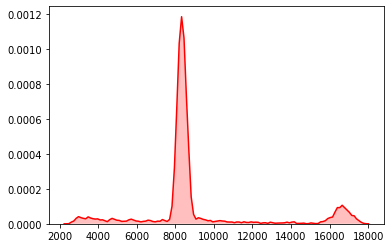

In [19]:
'''
for each row in xtrain, find indices of last non NaN values
'''
#renaming columns into 0,1,2,...
xtrain = xtrain.rename(columns={x:y for x,y in zip(xtrain.columns,range(0,len(xtrain.columns)))})

'''
last_valid_idx contains the column index for last non-NaN value in the rows of xtrain
'''
last_valid_idx = []

for i in range(0,xtrain.shape[0]):
    row = xtrain.iloc[i,:]
    idx = row.last_valid_index()
    last_valid_idx = np.append(last_valid_idx, idx)
    
'''
plotting kernel density of last_valid_idx
'''
ax = sb.kdeplot(last_valid_idx, shade=True, color="r")

'''
from the kernel density plot, we notice that the majority of series 
starts to show NaN's after the ~8500 index point. We will then first 
attempt classification by truncating all the series at the 7500
column. We will then pad the series which present NaNs before the 7500
columns with the median of the other series. This is just a first trial.
'''

'''
truncate xtrain at 7500 columns -- this prevents us from wasting too much data in truncating
'''
#note to self: load_data() reshiffles the data
xtrain_tr = xtrain.iloc[:,0:7500]

In [20]:
'''
pad shorter series
'''

#consider all rows of xtrain_tr with no NaN's
#Note: we only need to drop all rows with NaN at the last column entry 

#entry i is True if entry is last column in row i of xtrain_tr is NaN 
is_nan = np.isnan(xtrain_tr.iloc[:,-1].values) 
xtrain_tr1 = xtrain_tr[is_nan == False]  #shape = (4565, 7500)
xtrain_tr2 = xtrain_tr[is_nan == True]

#calculate column medians 
medians = np.array(xtrain_tr1.median(axis=0))

for j in xtrain_tr2.columns:
    xtrain_tr2.iloc[:,j] = xtrain_tr2.iloc[:,j].fillna(value = medians[j], axis = 0)
#   print(j)

xtrain_tr_filled = pd.concat([xtrain_tr1, xtrain_tr2])

'''
final dataset: xtrain_tr_filled
dimension: (5117, 7500)
shorter series padded
'''

print(xtrain_tr_filled.isnull().values.any())

'''
from now on, we operate on xtrain_tr_filled -- shape (5117, 7500)
'''

False


'\nfrom now on, we operate on xtrain_tr_filled -- shape (5117, 7500)\n'

# Models - (andiamooo)

In [ ]:
'''
AVOID THIS BOI FOR NOW --- SEE CODE BELOW
'''

'''

create train, validation, test splits
xtrain_nn, xval_nn, xtest_nn


xtrain_provisional_nn, xtest_nn, ytrain_provisional_nn, ytest_nn = train_test_split(xtrain_tr_filled, 
                                                          ytrain, test_size=0.1, random_state=42)

xtrain_nn, xval_nn, ytrain_nn, yval_nn = train_test_split(xtrain_provisional_nn,   # test set = val set 
                                                          ytrain_provisional_nn, test_size=0.3, random_state=42)

xtrain_nn = xtrain_nn.values.reshape((xtrain_nn.shape[0], xtrain_nn.shape[1], 1))
xval_nn = xval_nn.values.reshape((xval_nn.shape[0], xval_nn.shape[1], 1))
xtest_nn = xtest_nn.values.reshape((xtest_nn.shape[0], xtest_nn.shape[1], 1))

'''
'''
use now: xtrain_nn, xval_nn, xtest_nn
'''

In [21]:
'''
dataset reduced to 101 rows to see whether nn's train correctly

### code above is the original one ###
'''

xtrain_tr_filled_trial = xtrain_tr_filled.iloc[0:100, ]
ytrain = ytrain.iloc[0:100,]

xtrain_provisional_nn, xtest_nn, ytrain_provisional_nn, ytest_nn = train_test_split(xtrain_tr_filled_trial, 
                                                          ytrain, test_size=0.1, random_state=42)

xtrain_nn, xval_nn, ytrain_nn, yval_nn = train_test_split(xtrain_provisional_nn,   # test set = val set 
                                                          ytrain_provisional_nn, test_size=0.3, random_state=42)



xtrain_nn = xtrain_nn.values.reshape((xtrain_nn.shape[0], xtrain_nn.shape[1], 1))
xval_nn = xval_nn.values.reshape((xval_nn.shape[0], xval_nn.shape[1], 1))
xtest_nn = xtest_nn.values.reshape((xtest_nn.shape[0], xtest_nn.shape[1], 1))

# LSTM for Time Series

based on: https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

In [33]:
model = Sequential()
model.add(LSTM(64, input_shape = (xtrain_nn.shape[1],1)))
model.add(Dense(1, activation = 'sigmoid'))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''
Train the model and monitor the validation accuracy
'''

adam = Adam(lr=0.1) ## to be tuned
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(xtrain_nn, ytrain_nn, epochs=200, batch_size=20, callbacks=[chk], validation_data=(xval_nn,yval_nn))



Train on 63 samples, validate on 27 samples
Epoch 1/200
63/63 [==============================] - 36s 577ms/step - loss: 0.8344 - accuracy: 0.3651 - val_loss: 0.6952 - val_accuracy: 0.0741
Epoch 2/200
63/63 [==============================] - 34s 536ms/step - loss: 0.8521 - accuracy: 0.1746 - val_loss: 0.7522 - val_accuracy: 0.0741
Epoch 3/200
63/63 [==============================] - 33s 529ms/step - loss: 0.6157 - accuracy: 0.1905 - val_loss: 1.0138 - val_accuracy: 0.0741
Epoch 4/200
63/63 [==============================] - 35s 552ms/step - loss: 0.3052 - accuracy: 0.3016 - val_loss: 0.8695 - val_accuracy: 0.1852
Epoch 5/200
63/63 [==============================] - 36s 570ms/step - loss: 0.3320 - accuracy: 0.3175 - val_loss: 0.8867 - val_accuracy: 0.1852
Epoch 6/200
63/63 [==============================] - 36s 572ms/step - loss: 0.2311 - accuracy: 0.3016 - val_loss: 1.0850 - val_accuracy: 0.2593
Epoch 7/200
63/63 [==============================] - 40s 634ms/step - loss: 0.1898 - accurac

# Convolutional Neural Net -- Type I

based on: https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57

In [30]:
'''
this base model is one branch of the main model
it takes a time series as an input, performs 1-D convolution, 
and returns it as an output ready for concatenation
'''


def get_base_model(input_len, fsize):
    #the input is a time series of length n and width 1
    input_seq = Input(shape = (input_len, 1))
    #choose the number of convolution filters
    nb_filters = 10
    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

'''
this is the main model
it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
'''

# convolution filter sizes: fsizes = [8,16,24]

def main_model(inputs_lens = [512, 1024, xtrain_tr_filled.shape[1]], fsizes = [8,16,24]):
    
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape = (inputs_lens[0], 1)) # 1 = width of time series
    input_medseq = Input(shape = (inputs_lens[1] , 1))
    input_origseq = Input(shape = (inputs_lens[2], 1))
    
    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    
    #concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    out = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    
    return model

In [32]:
main_model(inputs_lens = [512, 1024, xtrain_tr_filled.shape[1]], fsizes = [8,16,24])
model.fit(xtrain_nn, ytrain_nn, epochs=200, batch_size=20)

Epoch 1/200
63/63 [==============================] - 18s 284ms/step - loss: -0.1082 - accuracy: 0.4127
Epoch 2/200
63/63 [==============================] - 22s 350ms/step - loss: -0.1790 - accuracy: 0.4127
Epoch 3/200
63/63 [==============================] - 20s 315ms/step - loss: -0.2132 - accuracy: 0.4127
Epoch 4/200
63/63 [==============================] - 20s 311ms/step - loss: -0.2535 - accuracy: 0.3968
Epoch 5/200
63/63 [==============================] - 20s 322ms/step - loss: -0.3174 - accuracy: 0.4127
Epoch 6/200
63/63 [==============================] - 20s 313ms/step - loss: -0.3754 - accuracy: 0.4286
Epoch 7/200
63/63 [==============================] - 20s 320ms/step - loss: -0.4272 - accuracy: 0.4444
Epoch 8/200
63/63 [==============================] - 21s 338ms/step - loss: -0.4355 - accuracy: 0.4762
Epoch 9/200
63/63 [==============================] - 20s 318ms/step - loss: -0.4801 - accuracy: 0.4762
Epoch 10/200
63/63 [==============================] - 19s 309ms/step - lo

KeyboardInterrupt: 

# Convolutional Neural Net -- Type II

based on: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

In [ ]:
'''
continue from here
'''